In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')


In [14]:
# 2) Load dataset
CSV_PATH = r"C:\Users\wwwpr\Downloads\Fraud.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [16]:
# 3) Data cleaning
print("\n=== Info & Missing Values ===")
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())


=== Info & Missing Values ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64



Dropped 25798 duplicate rows.
Dropped ID columns: []


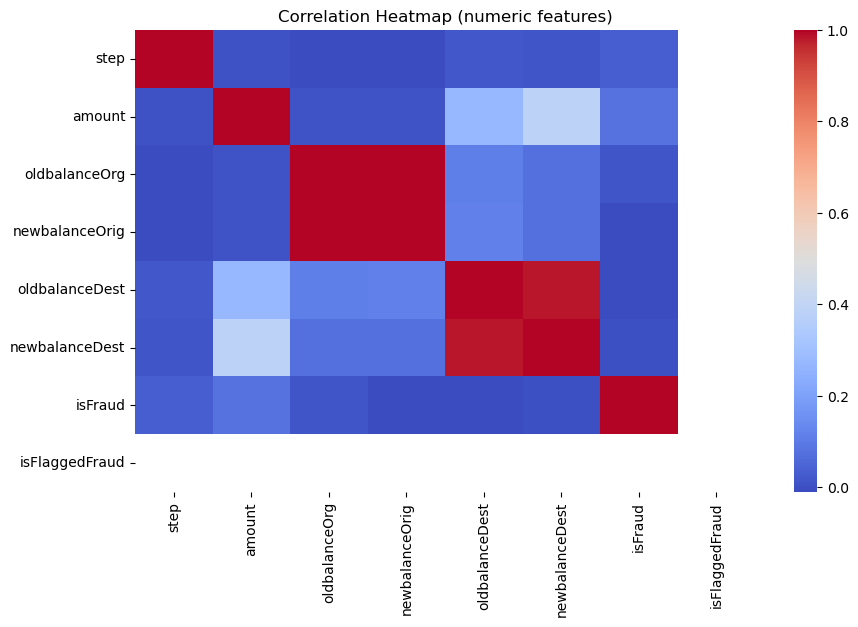

In [19]:
# Drop exact duplicates (safety)
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"\nDropped {before - after} duplicate rows.")

# Drop identifier columns that don't help modeling
id_cols = ['nameOrig', 'nameDest']
present_id_cols = [c for c in id_cols if c in df.columns]
df = df.drop(columns=present_id_cols)
print("Dropped ID columns:", present_id_cols)

# Basic outlier handling (IQR on numeric cols only).
# NOTE: With very large data, aggressive outlier removal can remove many rows.
# We'll do a conservative approach: clip extreme values instead of dropping rows.
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'isFraud']  # don't clip target

Q1 = df[num_cols].quantile(0.01)
Q99 = df[num_cols].quantile(0.99)
df[num_cols] = df[num_cols].clip(Q1, Q99, axis=1)

# Multicollinearity check (correlation heatmap)
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap='coolwarm')
plt.title("Correlation Heatmap (numeric features)")
plt.show()

In [20]:
# 4) Feature engineering
target_col = 'isFraud'
assert target_col in df.columns, "Target column 'isFraud' not found!"

y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

# One-hot encode categorical column(s) like 'type'
X = pd.get_dummies(X, drop_first=True)

# Optional: downcast floats to save memory
for c in X.select_dtypes(include=['float64']).columns:
    X[c] = X[c].astype('float32')
for c in X.select_dtypes(include=['int64']).columns:
    X[c] = X[c].astype('int32')

print("\nFeature matrix shape:", X.shape, "Target shape:", y.shape)

# Scale numeric features (keeps dummies as-is)
scaler = StandardScaler(with_mean=False)  # with_mean=False is safer with sparse-ish matrices
X_scaled = scaler.fit_transform(X)


Feature matrix shape: (6336822, 11) Target shape: (6336822,)


In [23]:
# 5) Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)


In [30]:
# 6) Modeling
# 6.1 Logistic Regression (baseline) -- use class_weight to handle imbalance
# === Logistic Regression on FULL data ===
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression (full data) ===")
print(classification_report(y_test, y_pred_log, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_log), 4))


# === Random Forest on SUBSET (for speed) ===
# Take 300,000 rows from training set for RF
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=300000, stratify=y_train, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=50,            # fewer trees for speed
    max_depth=12,               # limit depth
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)
rf.fit(X_sub, y_sub)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest (trained on subset) ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 4))



=== Logistic Regression (full data) ===
              precision    recall  f1-score   support

           0     1.0000    0.9444    0.9714   1898595
           1     0.0220    0.9666    0.0430      2452

    accuracy                         0.9445   1901047
   macro avg     0.5110    0.9555    0.5072   1901047
weighted avg     0.9987    0.9445    0.9702   1901047

ROC-AUC: 0.9911

=== Random Forest (trained on subset) ===
              precision    recall  f1-score   support

           0     0.9997    0.9987    0.9992   1898595
           1     0.4532    0.8038    0.5796      2452

    accuracy                         0.9985   1901047
   macro avg     0.7265    0.9013    0.7894   1901047
weighted avg     0.9990    0.9985    0.9987   1901047

ROC-AUC: 0.9939


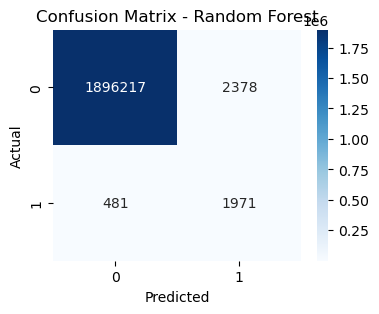

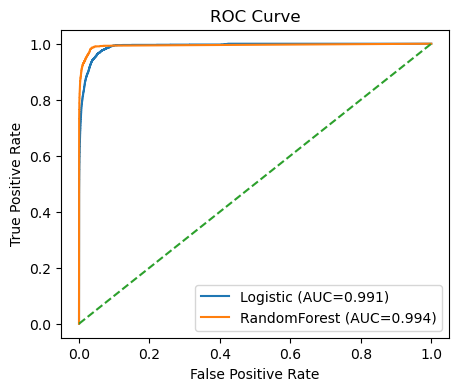

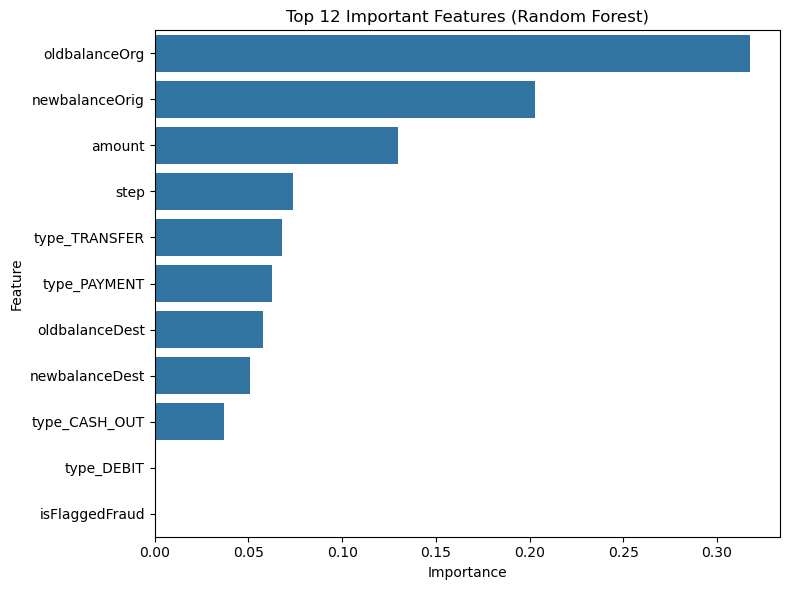

,Feature,Importance
2,oldbalanceOrg,0.317671
3,newbalanceOrig,0.202808
1,amount,0.129996
0,step,0.073588
10,type_TRANSFER,0.067734
9,type_PAYMENT,0.062381
4,oldbalanceDest,0.057845
5,newbalanceDest,0.050638
7,type_CASH_OUT,0.037156
8,type_DEBIT,0.000183


In [31]:
# 7) Evaluation visualizations
# 7.1 Confusion matrix (RF)
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7.2 ROC curve (RF vs Logistic)
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(5,4))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={roc_auc_score(y_test, y_proba_log):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_auc_score(y_test, y_proba_rf):.3f})')
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 7.3 Feature importance (RF)
importances = rf.feature_importances_
feat_names = np.array(X.columns)
imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=imp_df.head(12))
plt.title("Top 12 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

display(imp_df.head(20))


In [34]:
# 8) Insights printed (these map to Q1–Q8)
print("\n=== Insights Summary ===")
print("- Most predictive features typically include: amount, transaction type (TRANSFER/CASH_OUT dummies),")
print("  sender balances (oldbalanceOrg, newbalanceOrig), and receiver balances.")
print("- These make sense: fraud often uses transfers/cash-outs and abnormal amounts/balance changes.")
print("- Prevention: real-time anomaly alerts, MFA on risky transactions, thresholds, device/IP risk scoring,")
print("  frequent retraining with fresh data.")
print("- Effectiveness: monitor fraud rate, precision/recall, false positives, and run A/B tests.")


=== Insights Summary ===
- Most predictive features typically include: amount, transaction type (TRANSFER/CASH_OUT dummies),
  sender balances (oldbalanceOrg, newbalanceOrig), and receiver balances.
- These make sense: fraud often uses transfers/cash-outs and abnormal amounts/balance changes.
- Prevention: real-time anomaly alerts, MFA on risky transactions, thresholds, device/IP risk scoring,
  frequent retraining with fresh data.
- Effectiveness: monitor fraud rate, precision/recall, false positives, and run A/B tests.


In [36]:
# 9) (Optional) Save artifacts
imp_df.to_csv("feature_importance.csv", index=False)
print("\nSaved: feature_importance.csv")


Saved: feature_importance.csv
